In [3]:
import numpy as np
from utils import set_seed
from GaussianMixturePrior import GaussianMixturePrior
import torch
from torch.utils.data import DataLoader, TensorDataset
import importlib
import matplotlib.pyplot as plt

In [ ]:
# Recover datasets from files
data = np.load('../data/mnist_data.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']
print("Datasets loaded from mnist_data.npz")

set_seed(42)

X_train_tensor = torch.tensor(X_train.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Datasets loaded from mnist_data.npz
Seed set to: 42
Train set: (50000, 784) (50000,)
Validation set: (10000, 784) (10000,)
Test set: (10000, 784) (10000,)


In [1]:
SCALE = 1.0
MODEL = "hybrid_v3_1x1"
OPTIMIZER = "Adam"
TRANSFORM = 0.25
DROPOUT = 0.1
TYPE = "best_loss"

In [ ]:
module = importlib.import_module(MODEL)
GeneralFlow = getattr(module, 'GeneralFlow')

prior = GaussianMixturePrior(total_dim=784, num_classes=10, device=device, scale=SCALE, fixed_means=True)
model = GeneralFlow().to(device)

checkpoint = torch.load(f"../experiments/models/GMM/{TYPE}_{SCALE}_{MODEL}_{OPTIMIZER}_{TRANSFORM}_{DROPOUT}.pth")
model.load_state_dict(checkpoint['model_state_dict'])
prior.load_state_dict(checkpoint['prior_state_dict'])
prior.means = checkpoint['means']
print (f"Epoch: {checkpoint['epoch']}")

import scipy.stats as stats

def estimate_accuracy(loader, n_runs=50):
    accuracies = []
    for _ in range(n_runs):
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                # dequantize
                batch_X = (batch_X * 255.0 + torch.rand_like(batch_X)) / 256.0
                batch_X = batch_X - 0.5
                z, _ = model(batch_X)
                z = z.view(-1, 784)
                preds = prior.classify(z)
                if isinstance(preds, tuple):
                    preds = preds[0]
                correct += (preds == batch_y).sum().item()
                total += batch_y.size(0)
        acc = correct / total
        accuracies.append(acc)
    return np.array(accuracies)

set_seed(42)

model.eval()
prior.eval()

# Validation
val_accs = estimate_accuracy(val_loader, n_runs=10)
val_mean = val_accs.mean()
val_std = val_accs.std(ddof=1)
val_ci = stats.t.interval(0.95, len(val_accs)-1, loc=val_mean, scale=val_std/np.sqrt(len(val_accs)))
print(f"Validation accuracy: {val_mean:.4f} ± {val_ci[1]-val_mean:.4f} (95% CI)")

# Test
test_accs = estimate_accuracy(test_loader, n_runs=10)
test_mean = test_accs.mean()
test_std = test_accs.std(ddof=1)
test_ci = stats.t.interval(0.95, len(test_accs)-1, loc=test_mean, scale=test_std/np.sqrt(len(test_accs)))
print(f"Test accuracy: {test_mean:.4f} ± {test_ci[1]-test_mean:.4f} (95% CI)")

Epoch: 620
Seed set to: 42
Validation accuracy: 0.9914 ± 0.0003 (95% CI)
Test accuracy: 0.9930 ± 0.0003 (95% CI)


Temperature = 0

Seed set to: 42


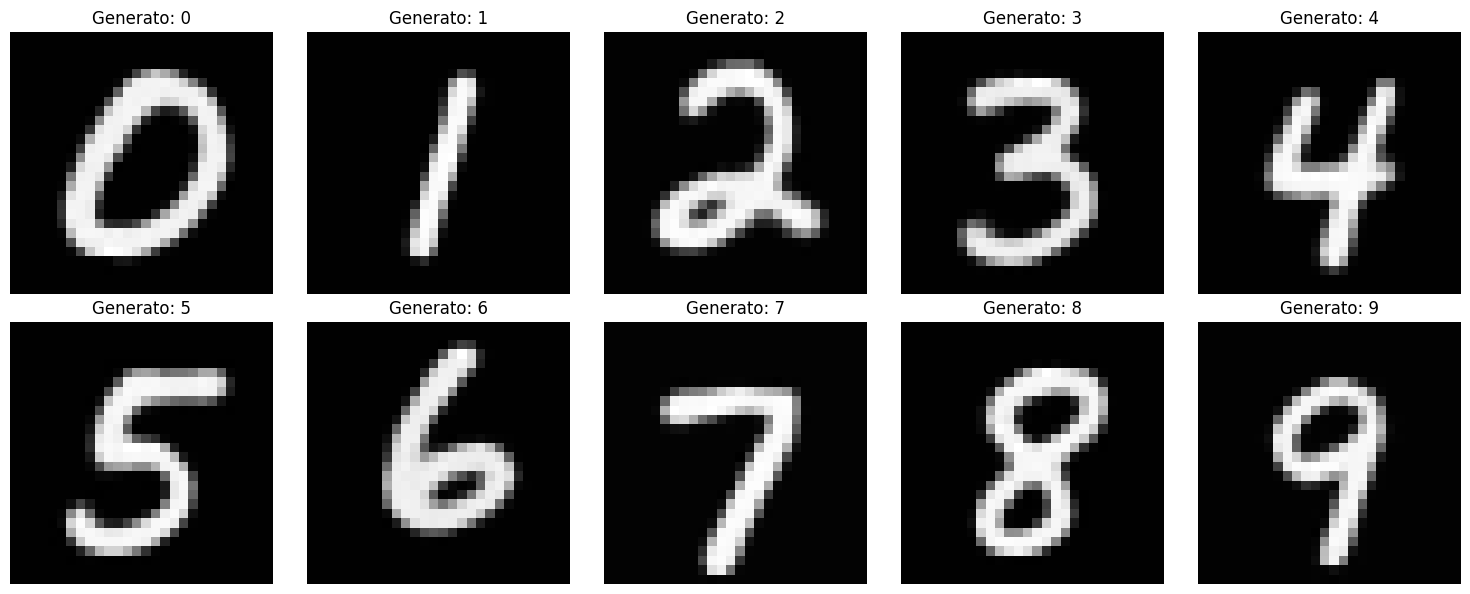

In [15]:
set_seed(42)

model.eval()

targets = list(range(10))
temp = 0

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
with torch.no_grad():
    for idx, target in enumerate(targets):
        z = prior.means[target].unsqueeze(0).to(device) + torch.randn(1, prior.means.shape[1]).to(device) * temp
        z_structural = z.view(1, 4, 14, 14)
        img_gen = model.inverse(z_structural)
        ax = axes[idx // 5, idx % 5]
        ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
        ax.set_title(f"Generato: {target}")
        ax.axis('off')
plt.tight_layout()
plt.show() 

Temperature = 0.25

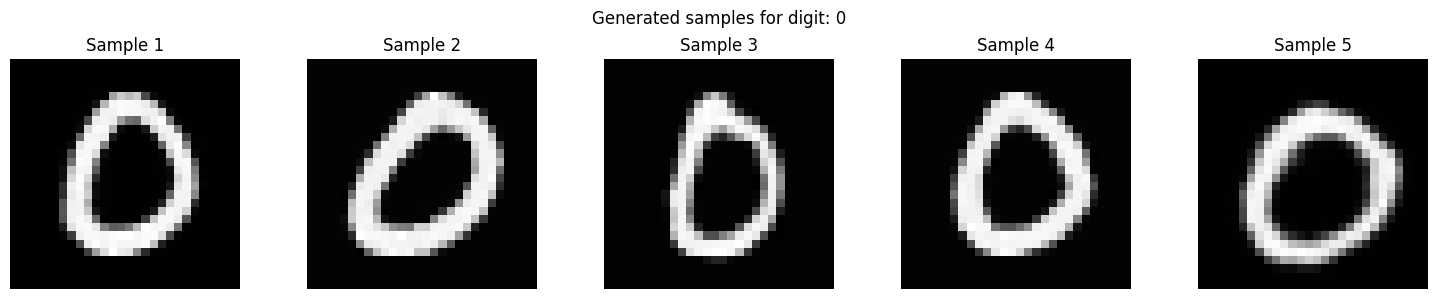

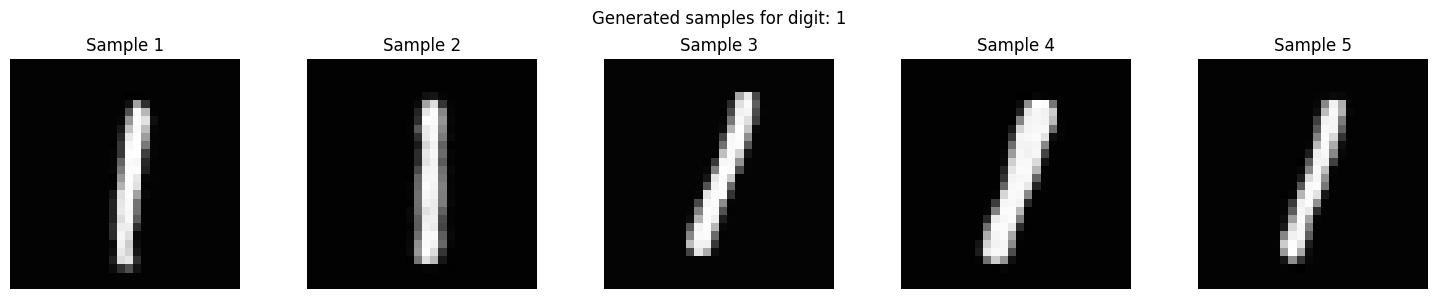

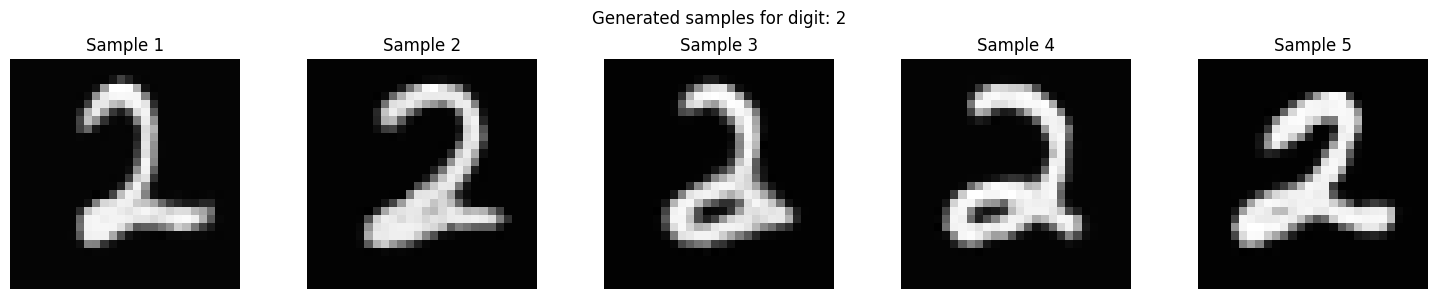

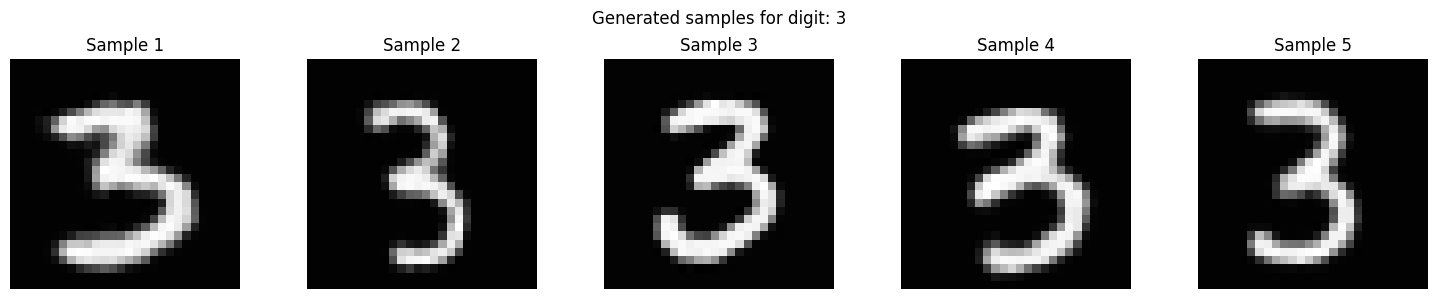

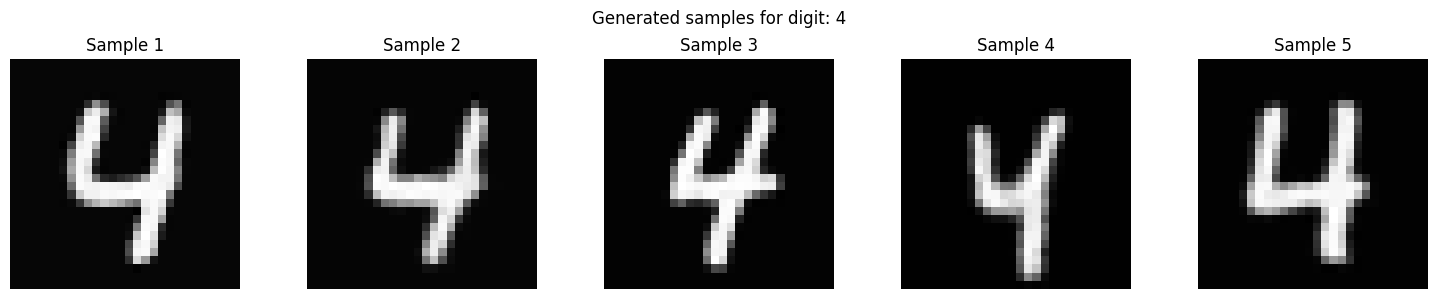

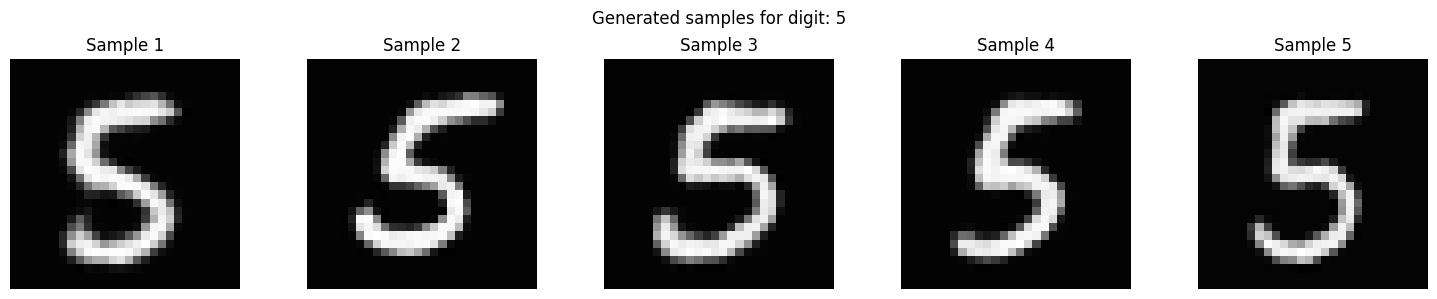

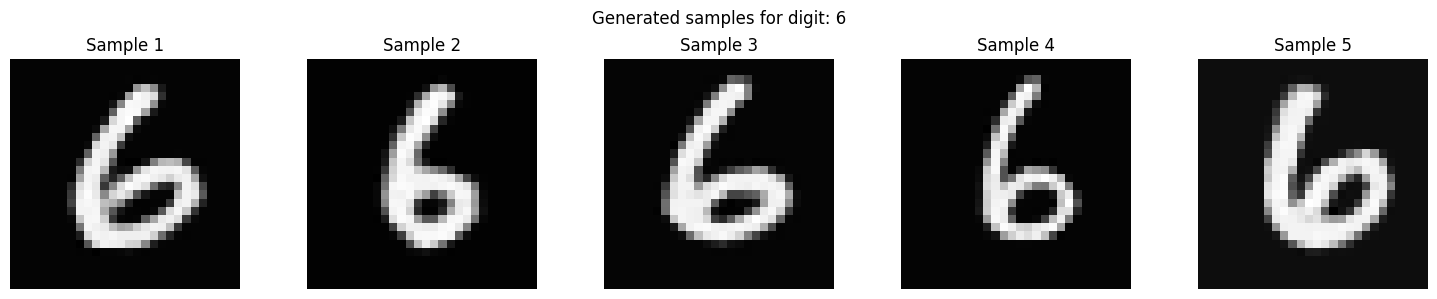

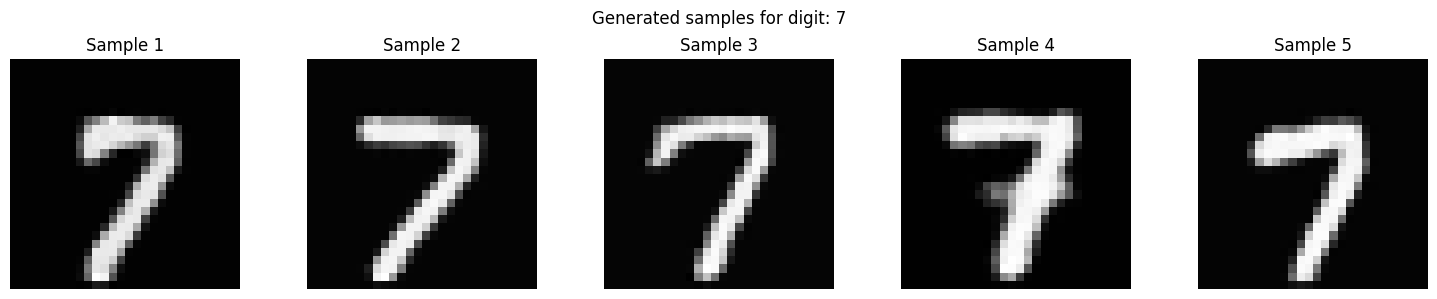

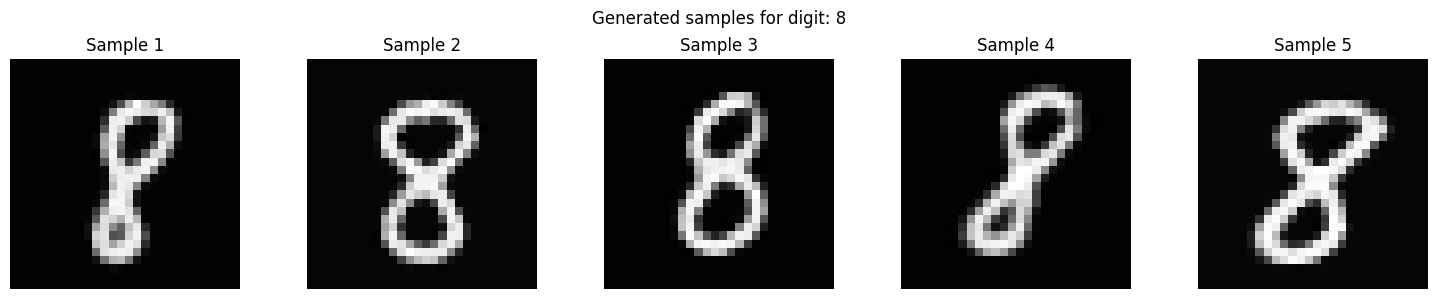

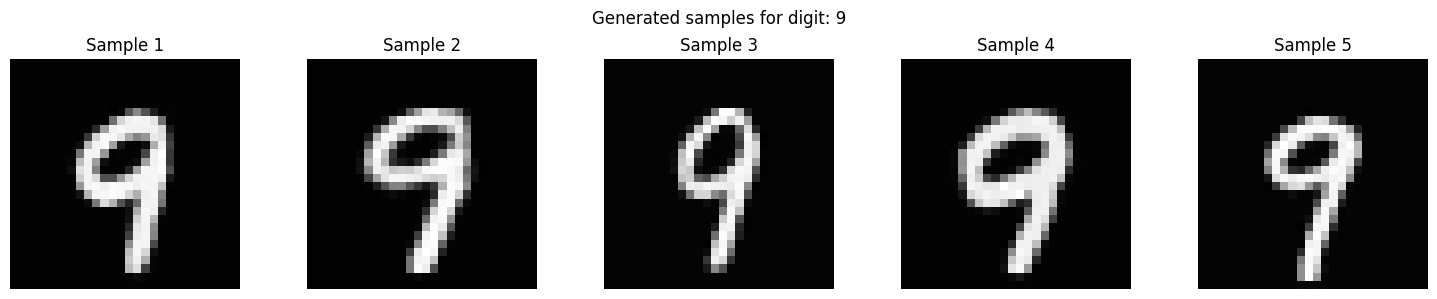

In [ ]:
model.eval()

targets = list(range(10))
temp = 0.25

figs = []
with torch.no_grad():
    for target in targets:
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for i in range(5):
            z = prior.means[target].unsqueeze(0).to(device) + torch.randn(1, prior.means.shape[1]).to(device) * temp
            z_structural = z.view(1, 4, 14, 14)
            img_gen = model.inverse(z_structural)
            ax = axes[i]
            ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
            ax.set_title(f"Sample {i+1}")
            ax.axis('off')
        plt.suptitle(f"Generated samples for digit: {target}")
        plt.tight_layout()
        plt.show()
        figs.append(fig)

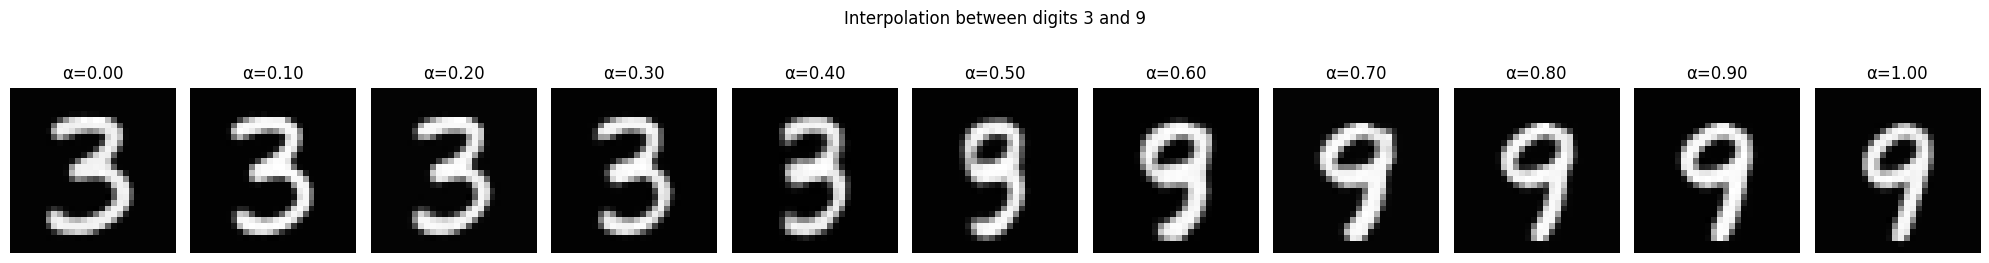

In [16]:
# Generate interpolations between digits 1 and 7
model.eval()
digit_a = 3
digit_b = 9
num_steps = 11
temp = 0.1
fig, axes = plt.subplots(1, num_steps, figsize=(20, 3))
with torch.no_grad():
    mean_a = prior.means[digit_a].unsqueeze(0).to(device)
    mean_b = prior.means[digit_b].unsqueeze(0).to(device)
    for i, alpha in enumerate(np.linspace(0, 1, num_steps)):
        z = (1 - alpha) * mean_a + alpha * mean_b
        z += torch.randn(1, prior.means.shape[1]).to(device) * temp
        z_structural = z.view(1, 4, 14, 14)
        img_gen = model.inverse(z_structural)
        ax = axes[i]
        ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
        ax.set_title(f"α={alpha:.2f}")
        ax.axis('off')
plt.suptitle(f"Interpolation between digits {digit_a} and {digit_b}")
plt.tight_layout()
plt.show()